In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# **I. Preparation**
- Loading data
- Initializing strategy

In [2]:
# ===== I. Load data =====
data = dt.load_dataList(ticker_list=['A', 'AAPL', 'GME', 'META'])

# ===== II. Making Samples =====
training_data = {}
testing_data = {}
embargo_data = {}

for ticker in data.keys():
    full_df = data[ticker].copy()
    full_df.index = pd.to_datetime(full_df['date'])
    training_data[ticker] = full_df.loc['2005-01-01':'2019-01-01']
    testing_data[ticker] = full_df.loc['2019-01-01': '2023-01-01']
    embargo_data[ticker] = full_df.loc['2023-01-01':]

full_training_data = pd.concat([training_data[ticker] for ticker in training_data.keys()], axis=0)

In [3]:
# ===== I. Define auxiliary parameters =====
non_feature_columns = ['date', 'code', 'exchange', 'open', 'high', 'low', 'close', 'volume', 'count_trx', 'label']
price_name = 'close'
date_name = 'date'
bid_open_name = 'open'
ask_open_name = 'open'
n_jobs = 9

# ===== II. Initialize ML strategy =====
strategy = lib.ML_strategy(n_jobs=n_jobs, date_name=date_name, bid_open_name=bid_open_name, ask_open_name=ask_open_name)
strategy = strategy.set_params(non_feature_columns=non_feature_columns, price_name=price_name)

# **II. Get Training Data**
- Apply Resampling/Labelling/Features
- Generate Folds and Rebalanced training set
- Apply features Selection

In [4]:
# ===== I. Define the models to extract Training Data =====
sampling_model = lib.DataSampler
labeller_model = lib.tripleBarrier_labeller
features_model = [
    lib.average_feature, 
    lib.minimum_feature, 
    lib.volatility_feature, 
    lib.quantile_feature, 
    lib.Z_momentum_feature, 
    lib.nonlinear_tempReg_feature, 
    lib.hurst_exponent_feature
]
cleaner_model = lib.FeaturesCleaner

# ===== II. Set the models to the strategy =====
strategy = strategy.set_models(
    sampling_model=sampling_model,
    labeller_model=labeller_model,
    features_model=features_model,
    cleaner_model=cleaner_model
)

In [5]:
# ===== III. Set the parameters for the models =====
sampling_params = {
    "sampling_method": "daily_volBars",
    "column_name": "volume",
    "grouping_column": "code",
    "new_cols_methods": "mean",
    "vol_threshold": 0.005,
    "aggregation_dict": {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "date": "first",
        "code": "first",
        "exchange": "first",
        "count_trx": "sum",
    }
}
labeller_params = {
    "upper_barrier": [1],
    "lower_barrier": [1.5],
    "vertical_barrier": [20],
    "vol_window": [20],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
features_params = {
    "window": [5, 10, 30, 60, 120],
    "power": [3, 4, 5],
    "quantile": [0.1, 0.9],
    "smoothing_method": [None, "ewma"],
    "window_smooth": [10],
    "lambda_smooth": [0.2],
}
cleaner_params = {
    'stationarity_threshold': 0.05,
    'outliers_threshold': 5,
}

# ===== IV. Set the parameters to the strategy =====
strategy = strategy.set_params(
    sampling_params=sampling_params,
    labeller_params=labeller_params,
    features_params=features_params,
    cleaner_params=cleaner_params
)

In [6]:
# ===== V. Set the data to the strategy =====
stacked_data, processed_data, features_informations = strategy.get_training_data(training_data=full_training_data)

Labelling data...


100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Extracting features...


100%|██████████| 4/4 [03:49<00:00, 57.31s/it]


In [7]:
# ===== I. Define Model for Rebalancing =====
splitSample_model = lib.TemporalUniquenessSplitter
splitSample_params = {
    'labels_name': "label",
    'price_name': "close",
    'n_samples': 2000,
    'replacement': False,
    'vol_window': 20,
    'upper_barrier': 1,
    'vertical_barrier': 20,
}

# ===== II. Set the model to the strategy =====
strategy = strategy.set_models(splitSample_model=splitSample_model)
strategy = strategy.set_params(splitSample_params=splitSample_params)

# ===== III. Get the rebalancing data =====
n_folds = 5
random_state = 42
folds, balanced_folds = strategy.split_and_resample(df=stacked_data, n_folds=n_folds, random_state=random_state)

In [8]:
# ===== I. Define Model for Feature Selection =====
featuresSelector_model = lib.NoCorrelationSelector
featuresSelector_params = {'correlation_threshold': 0.9}

# ===== II. Set the model to the strategy =====
strategy = strategy.set_models(featuresSelector_model=featuresSelector_model)
strategy = strategy.set_params(featuresSelector_params=featuresSelector_params)

# ===== III. Get the features selection data =====
training_df = strategy.features_selection(training_df=stacked_data)

# **III. Train Core Models**
- Tune Hyperparameters of the predictor
- Fit the predictor
- Calibrate the Meta model

In [9]:
# ===== I. Define Model for Predictor Tuning =====
predictor_model = lib.skLearnTreeClassifier

splitSample_model = lib.TemporalUniquenessSplitter
splitSample_params = {
    'labels_name': "label",
    'price_name': "close",
    'n_samples': 5000,
    'replacement': True,
    'vol_window': 20,
    'upper_barrier': 1,
    'vertical_barrier': 20,
}

gridSearch_model = lib.linearCV_GridSearch
gridSearch_params = {
    "criteria": "f1_score", 
    "n_folds": 5, 
    "balanced_training": False
}

gridUniverse = {
    'criterion': ['log_loss'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'ccp_alpha': [0.0],
    'class_weight': [None]
}

# ===== II. Set the models to the strategy =====
strategy = strategy.set_models(
    predictor_model=predictor_model,
    splitSample_model=splitSample_model,
    gridSearch_model=gridSearch_model
)
strategy = strategy.set_params(
    splitSample_params=splitSample_params,
    gridSearch_params=gridSearch_params,
    gridUniverse=gridUniverse
)

In [10]:
# ===== III. Tune the predictor Hyperparameters =====
best_params = strategy.tune_predictor(training_df=training_df)

# ===== IV. Fit the Predictor =====
strategy = strategy.fit(training_df=training_df)

Best score : 0.6175729103542587 for params : {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'ccp_alpha': 0.0, 'class_weight': None}


In [11]:
# ===== I. Define Meta Model =====
meta_model = lib.noFilter
metaGridUnivers = {}

# ===== II. Set the models to the strategy =====
strategy = strategy.set_models(meta_model=meta_model)
strategy = strategy.set_params(metaGridUniverse=metaGridUnivers)

# ===== III. Get the meta model data =====
cols = training_df.columns.to_list()
new_processed_data = []
for df in processed_data:
    new_df = df[cols].copy()
    new_processed_data.append(new_df)

profit_history = strategy.tune_meta(processed_data=new_processed_data, costs=0)

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


# **IV. Use the model**
- Process testing_data
- Make Predictions
- Backtest

In [12]:
test_data_A = strategy.process_data(df=testing_data['A'])

Labelling data...


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Extracting features...


100%|██████████| 1/1 [00:16<00:00, 16.72s/it]


Cleaning data...


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


1 dataframes cleaned
Selecting features...


100%|██████████| 1/1 [00:00<00:00, 334.10it/s]


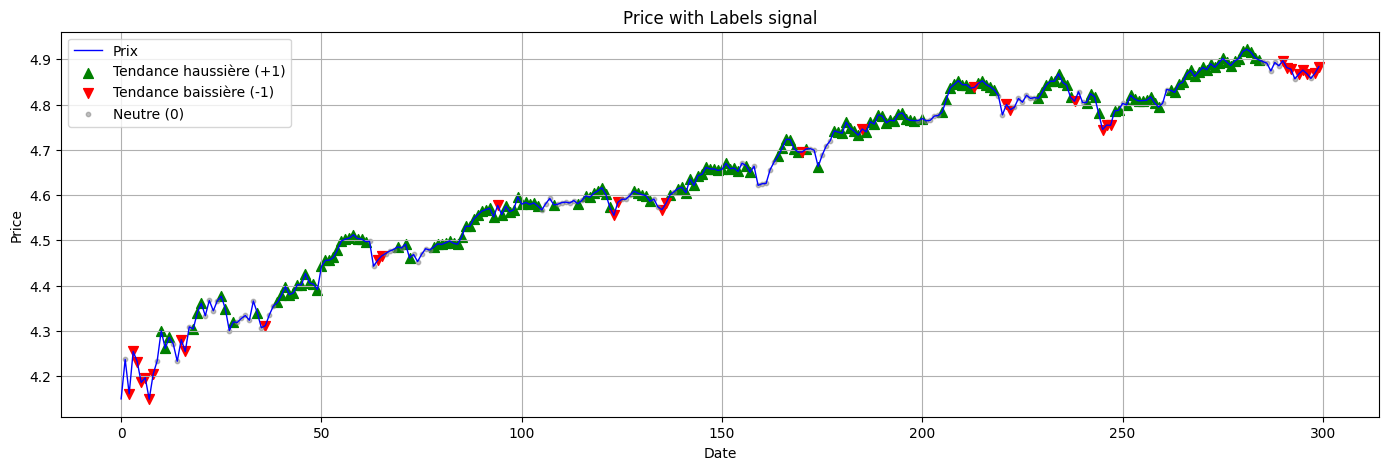

PnL total : -40.069999999999865


In [13]:
operations_df, signals_df = strategy.operate(df=test_data_A[0])
plotting_df = signals_df.iloc[:300].copy()
lib.plot_price_with_labels(np.log(plotting_df['close']), plotting_df['signal'].shift(1))
print(f'PnL total : {np.sum(operations_df["pnl"])}')

In [14]:
backtester = lib.Backtest(strategy=strategy)
backtester = backtester.set_params(
    n_jobs=1,
    brokerage_cost=0,
    slippage_cost=0
) 

full_operations_df, full_signals_df = backtester.run_backtest(data=testing_data['A'])

Labelling data...


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Extracting features...


100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


Cleaning data...


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


1 dataframes cleaned
Selecting features...


100%|██████████| 1/1 [00:00<00:00, 190.09it/s]


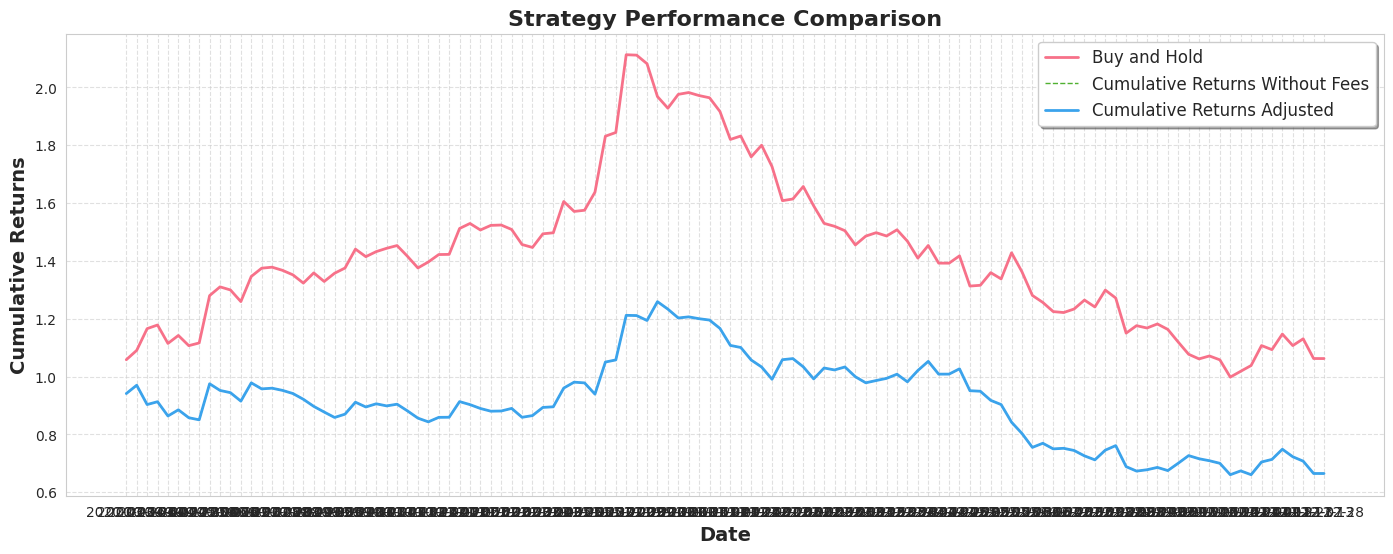

{'sharpe_ratio': np.float64(-1.1226219206484491),
 'sortino_ratio': np.float64(-2.235536761362243),
 'treynor_ratio': np.float64(-1.2152593891797867),
 'information_ratio': np.float64(-1.7746862810253183),
 'sterling_ratio': np.float64(-3.647746388383382),
 'calmar_ratio': np.float64(-1.4681149878408053)}

In [15]:
backtester.plot_operationsBars(by_date=True, buyHold=True, noFees=True, fees=True)

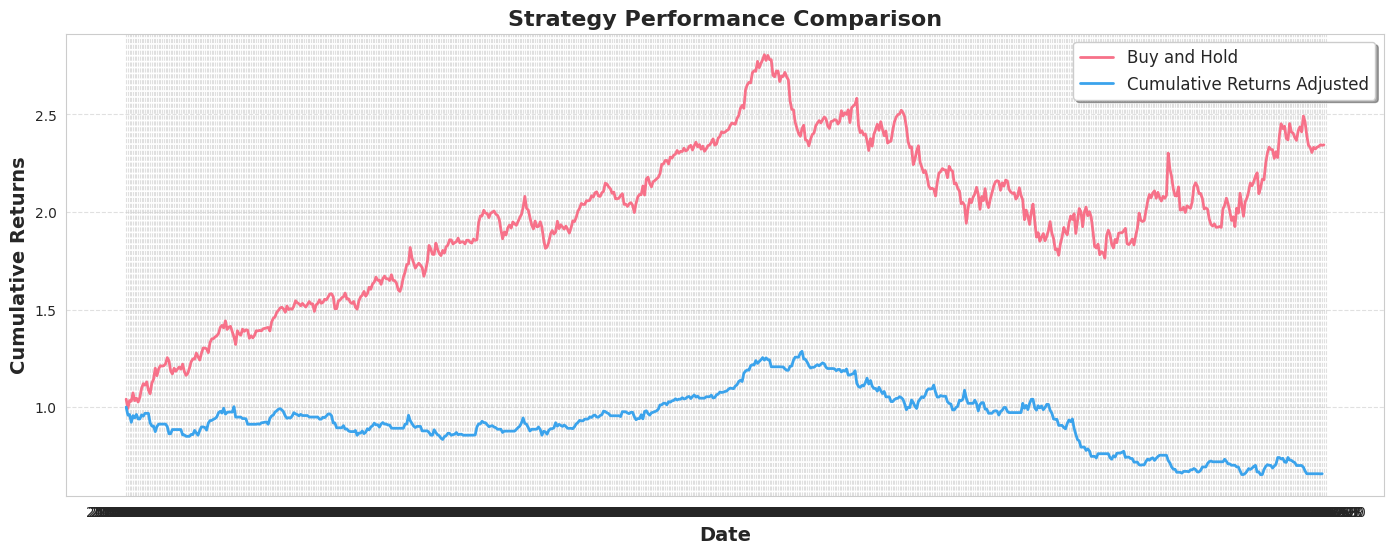

{'sharpe_ratio': np.float64(-0.5178775950095234),
 'sortino_ratio': np.float64(-0.662186458844463),
 'treynor_ratio': np.float64(-7.070360761082828),
 'information_ratio': np.float64(-1.2709406215414285),
 'sterling_ratio': np.float64(-0.7107767749039221),
 'calmar_ratio': np.float64(-0.24897048570117844)}

In [17]:
backtester.plot_timeBars()